In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn Pipelines 1

Goals:
- Principal Component Analysis (PCA) as dimensionality reduction technique.
- Scikit-learn pipelines

Notes:
- Fine-tuning the pipeline(s) is beyond the scope of this lecture.
- More complicated Scikit-learn pipelines will be explored in the next lectures.

## 1. Import and explore the iris dataset

The iris dataset is a very well-known dataset used in many lectures/examples.\
It consists of 3 different types of irises’ (Setosa, Versicolor, and Virginica) petal and sepal length, stored in a 150x4 numpy array.\
The rows are the 150 iris samples, the columns are the values measured for the sepal length, sepal width, petal length and petal width.

### 1.1 Quick exploration

In [2]:
iris = sns.load_dataset('iris')

Seaborn imports the dataset as a single pandas dataframe (iris) containing both the characteristics of the flower and their classification.

Alternative: input via scikit-learn

    from sklearn import datasets
    iris, target = datasets.load_iris(return_X_y=True, as_frame=True)

Scikit-learn imports the dataset as a pandas dataframe (iris) and a pandas series (target).\
'iris' contains the characteristics of the flower, and 'target' their classification (0, 1, or 2)

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

### 1.2 Problem setting

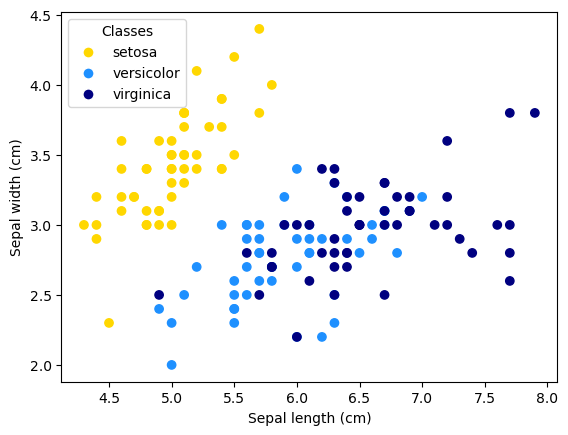

In [5]:
def plot_original_data(iris):

    from matplotlib.lines import Line2D
    colors = {'setosa':'gold', 'versicolor':'dodgerblue', 'virginica':'navy'}

    fig, ax = plt.subplots()
    scat = ax.scatter(iris.sepal_length, iris.sepal_width, c=iris.species.map(colors))
    ax.set(xlabel='Sepal length (cm)', ylabel='Sepal width (cm)')
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
    legend = ax.legend(handles = handles, loc='upper left', title='Classes') 

plot_original_data(iris)

The plot showsthat it is easy to classify the first class ('Setosa') based on 'Sepal length' and 'Sepal width'. However, in these coordinates, 'versicolor' and 'virginica' overlap and cannot be separated. There are a few pairs of coordinates that are better suited for this purpose. Here we want to explore another method, namely the PCA.

## 2. PCA decomposition: generalities

X = F(sepal_length, sepal_width, petal_length, petal_width)

PCA (**Principal Components Analysis**) transforms correlated features in the dataset into a set of linearly
independent (=orthogonal) features, named **principal components**.

X = $\lambda_1$ * PC1 + $\lambda_2$ * PC2 + $\lambda_3$ * PC3 + $\lambda_4$ * PC4

### 2.1 Mock data

We first create a random 3D dataset

In [6]:
def mock_data_for_pca(N):

    # initialize random generatof
    rng = np.random.RandomState(0)
    # arbitrary covariance matrix (hard-coded)
    cov = [[6.0, 3.0, 4.0], 
           [3.0, 3.0, 1.5], 
           [4.0, 1.5, 6.0]]
    X = rng.multivariate_normal(mean=[0, 0, 0], cov=cov, size=N)
    # check that cov is positive semi-definite
    if np.all(np.linalg.eigvals(cov) > 0):
        print('The covariance matrix is positive semi-definite')

    return X  

In [7]:
X = mock_data_for_pca(500) 

The covariance matrix is positive semi-definite


In [8]:
X.shape

(500, 3)

In [9]:
X

array([[-3.24718482e+00, -2.38794084e+00, -4.47835712e+00],
       [-4.70450598e+00, -1.60193266e-01, -6.72107689e+00],
       [-2.33813003e+00, -1.24933909e+00, -1.78859827e+00],
       ...,
       [ 1.67572833e+00,  4.79420253e-03,  2.11442332e+00],
       [ 5.57365738e+00,  4.15933174e+00,  3.00883985e+00],
       [-1.09390615e-01, -7.39811207e-01,  1.86601821e+00]])

In [10]:
# convert X as Pandas DataFrame
df_X  = pd.DataFrame(X, columns=['x', 'y', 'z'])
df_X.head()

,x,y,z
0,-3.247185,-2.387941,-4.478357
1,-4.704506,-0.160193,-6.721077
2,-2.338130,-1.249339,-1.788598
3,0.016628,-1.313284,-1.448207
4,-1.416525,-1.097202,-1.876052


### 2.2 Principal Component Analysis

The main parameter to select is the **number of principal components** in the final data.

In [11]:
from sklearn.decomposition import PCA
# run the pca:
pca = PCA(n_components=3).fit(X)
# get data in the new space of the principal components
Xpca = pca.fit_transform(X)
# transforms the outcome (numpy array) into pandas dataframe
columns = ['PC_%i' % (i+1) for i in range(3)]  # 'PC' stands for 'Principal Component'
                                               # i+1 to obtain PC_1 to PC_3 instead of PC_O for the coordinates in the 1st component
df_Xpca  = pd.DataFrame(Xpca, columns=columns)
df_Xpca.head()

,PC_1,PC_2,PC_3
0,-5.913364,0.888778,-0.959747
1,-7.406634,3.469003,0.837200
2,-3.217097,-0.131576,0.063297
3,-1.396790,0.271250,-1.416249
4,-2.568130,0.296532,-0.461787


In [12]:
def plot_3d_and_projection(X, pca, color, plot_kw):

   # plot_kw: keyword to plot eigenvectors either in the original space
   #                                           or in the principal components space

   if plot_kw == 'orig':
       xlabel = 'x'
       ylabel = 'y'
       zlabel = 'z'
       suptitle = 'Principal components in the original data space'
   if plot_kw == 'pca':
       xlabel = 'pc 1'
       ylabel = 'pc 2'
       zlabel = 'pc 3'
       suptitle = 'Principal components in the principal components space'
   
   #data
   (x, y, z) = (X[:,0], X[:,1], X[:,2])
   # eigenvectors:
   U=pca.components_[0]
   V=pca.components_[1]
   W=pca.components_[2]
   #eigenvalues:
   scu=pca.explained_variance_[0]
   scv=pca.explained_variance_[1]
   scw=pca.explained_variance_[2]

   # Create a Figure object
   fig, axs = plt.subplots(2, 2, figsize=(7,7))
   plt.suptitle(suptitle)
    
   # 1st plot 
   axs[0,0].scatter(x, z, color=color, s=2, alpha=0.3, label='data')
   axs[0,0].set_xlim([-10,10])
   axs[0,0].set_ylim([-10,10])
   axs[0,0].set_ylabel(zlabel)
   axs[0,0].tick_params(labelbottom=False)  
   # plot eigenvectors
   if plot_kw == ('orig'):
       axs[0,0].plot([0,scu*U[0]], [0, scu*U[2]], c='blue', lw=3, label = 'PC1')
       axs[0,0].plot([0,scv*V[0]], [0, scv*V[2]], c='green', lw=3, label = 'PC2')
       axs[0,0].plot([0,scw*W[0]], [0, scw*W[2]], c='red', lw=3, label = 'PC3')
   if plot_kw == ('pca'):
      axs[0,0].plot([0,scu], [0, 0], c='blue', lw=3, label = 'PC1')
      axs[0,0].plot([0,0], [0, 0], c='green', lw=3, label = 'PC2') # No data, just to have it in the legend
      axs[0,0].plot([0,0], [0, scw], c='red', lw=3, label = 'PC3')
   axs[0,0].legend(loc='upper left')
   
    
   # 2nd plot
   # remove the subplots to be set as 3d projections
   axs[0,1].remove()
   # add the subplots back as 3d projections
   axs[0,1] = fig.add_subplot(222, projection='3d', elev=-155, azim=-30)
   axs[0,1].scatter(x, y, z, color=color, s=1, alpha=0.3)
   axs[0,1].set_xlabel(xlabel, labelpad=1)
   axs[0,1].set_xlim3d([-10,10])
   axs[0,1].set_ylabel(ylabel, labelpad=1)
   axs[0,1].set_ylim3d([-10,10])
   axs[0,1].set_zlabel(zlabel, labelpad=1)
   axs[0,1].set_zlim3d([10,-10]) # REVERT AXIS
   # plot eigenvectors
   if plot_kw == ('orig'):
       axs[0,1].plot([0,scu*U[0]], [0, scu*U[1]], [0, scu*U[2]], c='blue', lw=3)
       axs[0,1].plot([0,scv*V[0]], [0, scv*V[1]], [0, scv*V[2]], c='green', lw=3)
       axs[0,1].plot([0,scw*W[0]], [0, scw*W[1]], [0, scw*W[2]], c='red', lw=3)
   if plot_kw == ('pca'):
       axs[0,1].plot([0,scu], [0, 0], [0, 0], c='blue', lw=3)
       axs[0,1].plot([0,0], [0, scv], [0, 0], c='green', lw=3)
       axs[0,1].plot([0,0], [0, 0], [0, scw], c='red', lw=3)

    
   # 3rd plot
   axs[1,0].scatter(x, y, color=color, s=2, alpha=0.3)
   axs[1,0].sharex(axs[0, 0])
   axs[1,0].set_xlim([-10,10])
   axs[1,0].set_xlabel(xlabel)
   axs[1,0].set_ylim([-10,10])
   axs[1,0].set_ylabel(ylabel)
   axs[1,0].tick_params(labeltop=False)
   # plot eigenvectors
   if plot_kw == ('orig'):
       axs[1,0].plot([0,scu*U[0]], [0, scu*U[1]], c='blue', lw=3)
       axs[1,0].plot([0,scv*V[0]], [0, scv*V[1]], c='green', lw=3)
       axs[1,0].plot([0,scw*W[0]], [0, scw*W[1]], c='red', lw=3) 
   if plot_kw == ('pca'):
       axs[1,0].plot([0,scu], [0,0], c='blue', lw=3, label = 'PC1')
       axs[1,0].plot([0,0], [0, scv], c='green', lw=3, label = 'PC2')
       
   # 4th plot
   axs[1,1].scatter(z, y, color=color, s=2, alpha=0.3)
   axs[1,1].sharey(axs[1,0])
   axs[1,1].set_xlim([-10,10])
   axs[1,1].set_xlabel(zlabel)
   axs[1,1].set_ylim([-10,10])
   axs[1,1].tick_params(labelleft=False)  
   # plot eigenvectors
   if plot_kw == ('orig'):
       axs[1,1].plot([0, scu*U[2]], [0, scu*U[1]], c='blue', lw=3)
       axs[1,1].plot([0, scv*V[2]], [0, scv*V[1]], c='green', lw=3)
       axs[1,1].plot([0, scw*W[2]], [0, scw*W[1]], c='red', lw=3)
   if plot_kw == ('pca'):
       axs[1,1].plot([0,scw], [0, 0], c='red', lw=3)
       axs[1,1].plot([0,0], [0, scv], c='green', lw=3) 
       
   #fig.subplots_adjust(hspace=0, wspace=0)
   fig.tight_layout()
   
   # Save figure
   # fig.savefig("pca.pdf", orientation='portrait', bbox_inches='tight')

In the original coordinates (x,y,z), the first principal component aligns with the most elongated feature as PCA attempts to include as much information as possible in the primary component.\
Then PCA attempts to put as much as possible of the remaining information in a second principal component, orthogonal to the first component so that it includes no redundant information.\
Then it continues until the nth component os reached. 

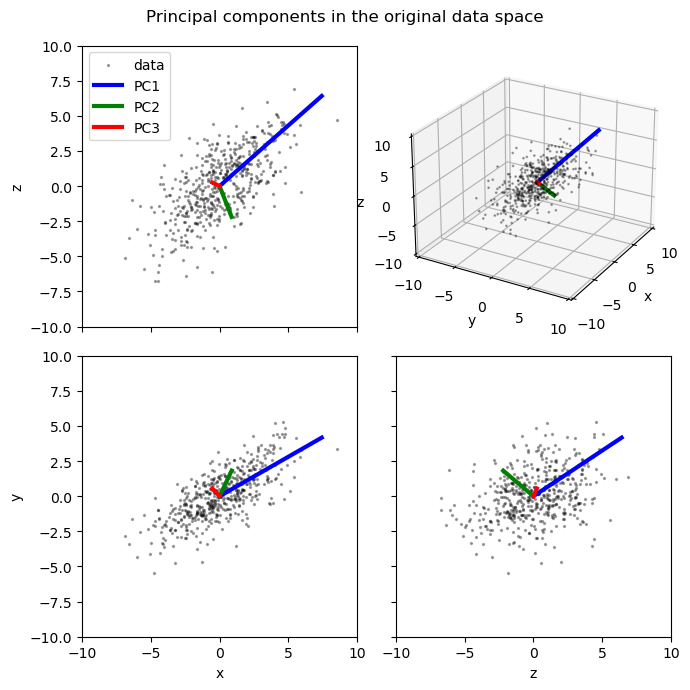

In [13]:
plot_3d_and_projection(X, pca, 'black', 'orig')

pca.components_ contains the coordinates of the principal components in the original (x,y,z) space.

In [14]:
pca.components_ 

array([[ 0.69670651,  0.39095836,  0.60145789],
       [ 0.29408339,  0.60908178, -0.73656931],
       [-0.65430497,  0.69005141,  0.30937688]])

In the plots above (and below), the principal components are scaled by their explained variance.\
Explained variance refers to the amount of variability in the original data that is captured by each principal component.

In [15]:
pca.explained_variance_ 

array([10.65176371,  2.98202586,  0.79276794])

If we plot the same data and principal components in the principal components' space, we obtain the figures below.\
Since the original and the final data are both 3D, the effect of PCA in this example is "only" to rotate the axes in order to bring them along the main axes of the ellipsoid.\
If we had chosen pca = PCA(n_components=2), the final data would be 2D, along the PC1 and PC2 principal components, as shown in the bottom left projection.

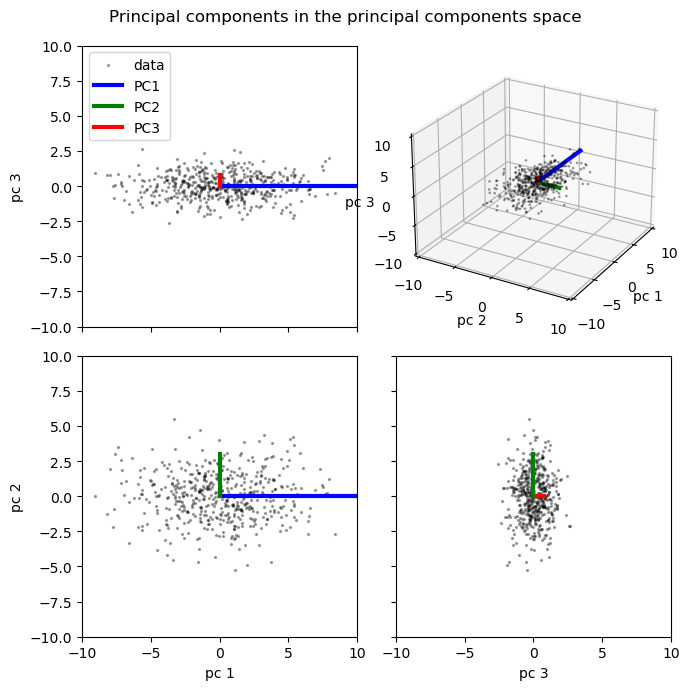

In [16]:
plot_3d_and_projection(Xpca, pca, 'black', 'pca')

Notes:
- PCA only works with numerical features.
- PCA is sensitive to scale, data should be standardized before applying PCA.
- PCA is sensitive to outliers.

It is possible to reconstruct the original data:
- either via: reconstructed = np.matmul(Xpca, pca.components_)
- or preferably using the built-in function: reconstructed2 = pca.inverse_transform(Xpca)-\
  
The reconstruction is not perfect, unless the number of dimensions remains the same (if not, some information has been lost).

In [17]:
pca2 = PCA(n_components=2).fit(X)
Xpca2 = pca2.fit_transform(X)

In [18]:
reconstructed2 = pca2.inverse_transform(Xpca2)
reconstructed2

array([[-3.87515189, -1.72566625, -4.18143366],
       [-4.15672157, -0.73790461, -6.98008735],
       [-2.29671441, -1.29301736, -1.80818094],
       ...,
       [ 1.35507356,  0.3429672 ,  2.26603942],
       [ 5.64108523,  4.08822013,  2.97695775],
       [-0.05228542, -0.80003622,  1.839017  ]])

In [19]:
diff = np.subtract(reconstructed2, X)
diff

array([[-0.62796707,  0.66227459,  0.29692346],
       [ 0.54778441, -0.57771134, -0.25901046],
       [ 0.04141562, -0.04367827, -0.01958267],
       ...,
       [-0.32065477,  0.338173  ,  0.15161611],
       [ 0.06742785, -0.07111161, -0.0318821 ],
       [ 0.0571052 , -0.06022501, -0.02700121]])

### 2.3 Dimensionality reduction 

#### 2.3.1 Generalities

Depending on the strategy adopted, it is possible to replace a large number of the original features with a smaller number of principal components. This is called **dimensionality reduction**.\
Dimensionality reduction can be performed via:
- **feature selection**: only a subset of the original features are kept,
- **feature extraction**: new features are created by combining original features (Ex: PCA),
- a mix of both.

#### 2.3.2 Pros and cons of dimensionality reduction.

Advantages of dimensionality reduction:
- Models that process very high dimensional data are time-consuming and/or expensive.
- Visualizing/interpreting more than 3D is often difficult.
- High dimensional data may contain noise (very little information in a given feature) or be redundant (several features are highly correlated).

Inconveniences of dimensionality reduction:
- Some information is lost (which can be seen in the performance metrics).
- In case dimensionality reduction comes with the creation of new features (like with PCA), the new features may not be straightforward to interpret.

Note: Dimensionality reduction is always a trade-off between simplification/speed and the amount of information retained.

#### 2.3.3 Selecting the principal components

Variance is a statistical measurement of the spread between numbers in a given dataset (the definition of variance indicates that it measures the distance between every point in the dataset and the dataset average value).
Higher variance means that there is more variability/dispersion in the data, and potentially more hidden patterns (thus more information).

Each principal component accounts for a given fraction of the total variance present in the data.\
**Explained variance** refers to the amount of variability in the original data that is captured by each principal component.\
**Explained variance ratio** is the same, expressed in terms of percentages.\
**Cumulative variance** is the cumulative sum of the explained variance (ratios) when considering more principal components.

The significance of each component diminishes from PC_1 to PC_n.\
The quantities listed above help deciding which of the n first components should be kept (see example in 2.4). 

**PCA Loadings** are the coefficients of the linear relation between the original variables (x,y,z) and the principal components (PC1, PC2, PC3).\
They help us understanding how much each original variable contributes to a given principal component.

In [20]:
# Note that we transpose the pca.components_ array so that the columns are the principal components and the row the original coordinates.
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=['x', 'y', 'z'])
loadings

,PC1,PC2,PC3
x,0.696707,0.294083,-0.654305
y,0.390958,0.609082,0.690051
z,0.601458,-0.736569,0.309377


Loadings can be indicative when performing feature engineering.

Note: PCA in scikit-learn comes with a default whiten=False keyword.\
Whiten=True returns PCA.components_ with unit variance (unit variance means that the variance / standard deviation of a sample tend to 1).\
This is needed in some cases (neural networks) but not in others (tree-based models).

### 2.4 PCA decomposition applied to the iris dataset

We apply a Principal Component Analysis (PCA) to the iris dataset.
Then we plot the irises across the first 3 PCA dimensions.

First we split the dataframe into 'data' (X) and 'target' (y)

In [21]:
iris_X = iris.loc[:, ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
iris_X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [22]:
iris_y = iris.iloc[:,-1]
print(iris_y.unique())
iris_y.head()

['setosa' 'versicolor' 'virginica']


0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: species, dtype: object

In [23]:
# Apply the PCA analysis to the iris dataset
from sklearn.decomposition import PCA
pca_iris = PCA(n_components=3).fit(iris_X)
X_reduced = pca_iris.fit_transform(iris_X)

In [24]:
# transforms the outcome (numpy array) into pandas dataframe
columns = ['PC_%i' % (i+1) for i in range(3)] 
# 'PC' stands for 'Principal Component'
# i+1 t obtain PC_1 to PC_3 instead of PC_O for the coordinates in the 1st component
df_reduced  = pd.DataFrame(X_reduced, columns=columns)
df_reduced.head()

,PC_1,PC_2,PC_3
0,-2.684126,0.319397,-0.027915
1,-2.714142,-0.177001,-0.210464
2,-2.888991,-0.144949,0.017900
3,-2.745343,-0.318299,0.031559
4,-2.728717,0.326755,0.090079


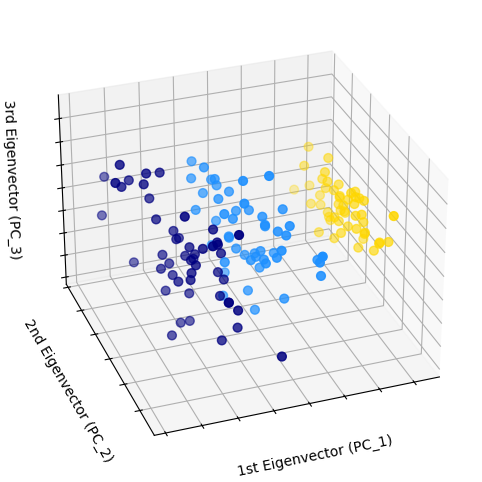

In [25]:
def plot_PCA_data(X_reduced, iris):

    colors = {'setosa':'gold', 'versicolor':'dodgerblue', 'virginica':'navy'}

    # initialize figure, axes
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

    # plot the PCA-reduced data provided as a numpy array)
    ax.scatter(X_reduced[:, 0],
               X_reduced[:, 1],
               X_reduced[:, 2],
               c=iris.species.map(colors),
               s=40,
               )

    #ax.set_title("First three PCA dimensions")
    ax.set_xlabel('1st Eigenvector (PC_1)')
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('2nd Eigenvector (PC_2)')
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel('3rd Eigenvector (PC_3)')
    ax.zaxis.set_ticklabels([])

    plt.show()

plot_PCA_data(X_reduced, iris)

PCA creates 3 new features that are a linear combination of the 4 original features.
In this new set of coordinates, it has become possible to differentiate between the three types of irises.

<Figure size 600x3600 with 0 Axes>

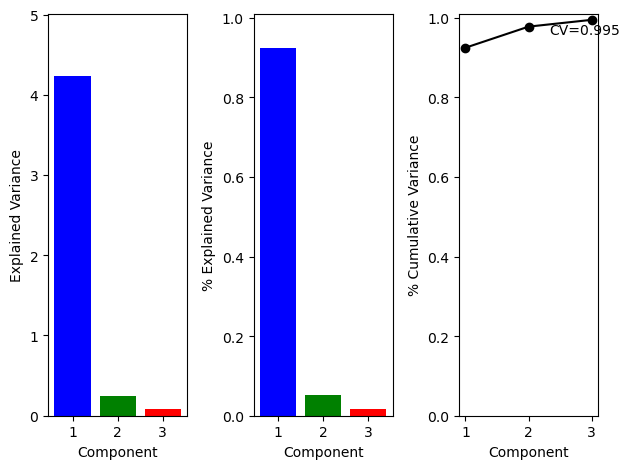

In [26]:
def plot_pca_variance(pca_object):

    colors = ['blue', 'green', 'red']

    # initialize figure, axes
    fig = plt.figure(figsize=(6, 36))
    fig, axs = plt.subplots(1, 3)
    n = pca_object.n_components_
    grid = np.arange(1, n + 1)

    # Explained variance
    ev = pca_object.explained_variance_
    axs[0].bar(grid, ev, color=colors)
    axs[0].set(xlabel="Component", ylabel="Explained Variance", ylim=(0.0, 5.01))
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[0].set_xticks(grid)
    axs[0].set_xticklabels(grid)

    # Explained variance ratio
    evr = pca_object.explained_variance_ratio_
    axs[1].bar(grid, evr, color=colors)
    axs[1].set(xlabel="Component", ylabel="% Explained Variance", ylim=(0.0, 1.01))
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[1].set_xticks(grid)
    axs[1].set_xticklabels(grid)

    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[2].plot(grid, cv, "o-", color='black')
    axs[2].set(xlabel="Component", ylabel="% Cumulative Variance", ylim=(0.0, 1.01))
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[2].set_xticks(grid)
    axs[2].set_xticklabels(grid)
    # Cumulative variance value on the 3rd plot
    axs[2].annotate(f'CV={cv[-1]:.3f}', (grid[-1], cv[-1]), \
                    textcoords="offset points", xytext=(-5,-10), ha='center')

    fig.tight_layout()

plot_pca_variance(pca_iris)

From these plots, we see that:
- PC 1, the first principal component, captures more than 90% of the variance.
- PC 2 captures almost 5%, PC 3 even less
- Considered together, we retain 99.5% of the original information by reducing the original 4 features to the 3 new features. 

Summary:
1. In principle, we should start with rescaling the data
2. Dimensionality reduction via PCA
3. Next step1: Model for classification
4. Next step2: Model evaluation

This is quite some coding, and we have to code it twice, once for the train sample and once for the test sample.
This is much easier to achieve within a **Pipeline**

## 3. Scikit-learn pipelines

### 3.1 Generalities

A typical ML workflow is as follows:

1. split data into training/testing sets.
2. each of them goes through data cleaning/preprocessing.
3. they are then used as input for a ML model.

To avoid repetitive coding (first dealing with the training set, then with the testing set), it is possible to write a scikit-learn **pipeline**.\
A pipeline chains every step of the data analysis sequentially, so that  the output of a given step is used as the input for the next step.

Additional advantages:
- Less prone to (copy/paste) mistakes.
- Workflow easier to understand.
- Less prone to data leakage

### 3.2 Pipeline creation using Pipeline()

The syntax of a pipeline is as follows:\
Pipeline(steps = [(‘step name’, transform function), …])

In [27]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
# PCA already imported
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
                    ('Scaler', StandardScaler()),
                    ('PCA', PCA(n_components=3)),
                    ('lr_classifier', LogisticRegression(random_state=0))
                   ])

It is possible to display the pipeline.\
Clicking on the image provides the details of each step. 

In [28]:
from sklearn import set_config

set_config(display='diagram')
display(pipeline_lr)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('lr_classifier', LogisticRegression(random_state=0))])

### 3.3 Pipeline creation using make_pipeline()

There is an alternative way to define a pipeline, using the 'make_pipeline()' function.

In [29]:
from sklearn.pipeline import make_pipeline
alt_pipeline = make_pipeline(StandardScaler(), PCA(n_components=3), LogisticRegression(random_state=0))
display(alt_pipeline)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('logisticregression', LogisticRegression(random_state=0))])

### 3.4 Running/evaluating the pipeline

#### 3.4.1 Split data in train/test sets

Note: This is just to follow the standard procedure, but the initial dataset is already small and splitting it will result in an even smaller training set.\
We try to mitigate that by adding the 'stratify' keyword applied to iris_y, to keep approximately the same distribution of the different species.

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, \
                                                    test_size=0.2, \
                                                    stratify=iris_y,
                                                    random_state=10)

#### 3.4.2 Train the model

In [31]:
# Pipeline.fit is the command to process data through the pipeline, including model fitting.
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('lr_classifier', LogisticRegression(random_state=0))])

#### 3.4.3 Evaluate the model

In [32]:
score_tr = pipeline_lr.score(X_train, y_train)
print('\nModel score (training data):', score_tr)


Model score (training data): 0.9583333333333334


In [33]:
score_te = pipeline_lr.score(X_test, y_test)
print('\nModel score: (testing data)', score_te)


Model score: (testing data) 1.0


Both results are similar so we are probably not overfitting.

Note: Pipeline.score computes the 'score' of the **final** estimator.\
Since the performance of the final estimator depends on the previous steps, this provides an evaluation of the entire pipeline (preprocessing + model).\
It is possible (and desirable) to test various combinations of preprocessing methods + models to achieve the best possible score 

To evaluate a model, it is however better to perform a cross-validation.\
Note that we can specify the cross-validation strategy and the corresponding hyperparameters.

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=5, shuffle=True)

In [36]:
cross_val_score(pipeline_lr, X_train, y_train, cv=cv, scoring='accuracy').mean()

0.95

#### 3.4.4 Predict the outcome on unseen data

In [37]:
# Pipeline.predict is the command to predict the outcome on unseen data thanks to the model trained just above.
y_pred = pipeline_lr.predict(X_test)

#### 3.4.5 Inspect the results

In [38]:
score_te = pipeline_lr.score(X_test, y_test)
print('\nModel score: (testing data)', score_te)


Model score: (testing data) 1.0


In [39]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [41]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


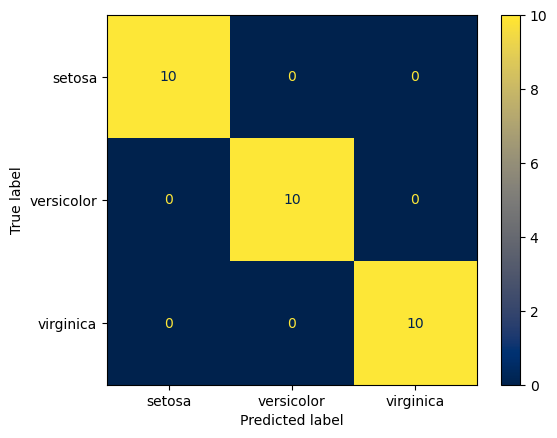

In [42]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['setosa', 'versicolor', 'virginica'])
cm_display.plot(cmap='cividis')

### 3.5 Creating other pipelines

In [43]:
# StandardScaler already imported
# PCA already imported
from sklearn.tree import DecisionTreeClassifier

pipeline_dt = Pipeline([
                    ('Scaler', StandardScaler()),
                    ('PCA', PCA(n_components=3)),
                    ('dt_classifier', DecisionTreeClassifier(random_state=0))
                   ])
display(pipeline_dt)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('dt_classifier', DecisionTreeClassifier(random_state=0))])

In [44]:
# StandardScaler already imported
# PCA already imported
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
                    ('Scaler', StandardScaler()),
                    ('PCA', PCA(n_components=3)),
                    ('rf_classifier', RandomForestClassifier(random_state=0))
                   ])
display(pipeline_rf)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('rf_classifier', RandomForestClassifier(random_state=0))])

### 3.6 Running and evaluating all pipelines

In [45]:
# Create a dictionnary of pipelines
pipe_dict = {0:'Logistic Regression',1:'Decision Tree',2:'Random Forest'}
# Create a list of pipelines
pipelines = [pipeline_lr,pipeline_dt,pipeline_rf]

In [46]:
# run all pipelines within a for loop
for pipe in pipelines:
    pipe.fit(X_train,y_train)

In [47]:
# Evaluate all pipelines within a for loop
for i, model in enumerate(pipelines):
    print('{} Test accuracy: {}'.format(pipe_dict[i],np.round(model.score(X_test,y_test)*100),1))

Logistic Regression Test accuracy: 100.0
Decision Tree Test accuracy: 100.0
Random Forest Test accuracy: 100.0


# Conclusiom

In [48]:
Pipelines:
1. make coding easier and the workflow easier to understand.
2. make the code less prone to data leakage.
3. make it possible to **cross-validate the entire pipeline**, not just the model.
4. make it possible to **tune the hyperparameters (for instance using GridSearch) for the entire pipeline**, not just the model.

SyntaxError: invalid syntax (1734749219.py, line 1)

We will do that in the nest lecture with more complicated pipelines.